In [226]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

Data

In [227]:
# Load the data
data = pd.read_csv('HPG.csv', parse_dates=['Date'])

# Convert 'Price' column to numeric
data['Price'] = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce')

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Sort the index
data.sort_index(inplace=True)

# Set the frequency of the index
data = data.asfreq('B')

# Fill missing values if any (forward fill)
data['Price'].fillna(method='ffill', inplace=True)

data = data['Price'].copy()
train = data[:'2022-02-28']
test = data['2022-03-01':'2023-03-31']

C:\Users\minht\AppData\Local\Temp\ipykernel_15196\672941967.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Price'].fillna(method='ffill', inplace=True)


In [228]:
data.describe()

count     1629.000000
mean     19963.068570
std       9135.227233
min       7411.800000
25%      12261.500000
50%      17818.000000
75%      25182.000000
max      43895.800000
Name: Price, dtype: float64

Augmented Dickey Fuller(ADF) test 

In [229]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)
print("ADF Statistics:", result[0])
print("p-value", result[1])

ADF Statistics: -0.03235744804953357
p-value 0.9557729319084693


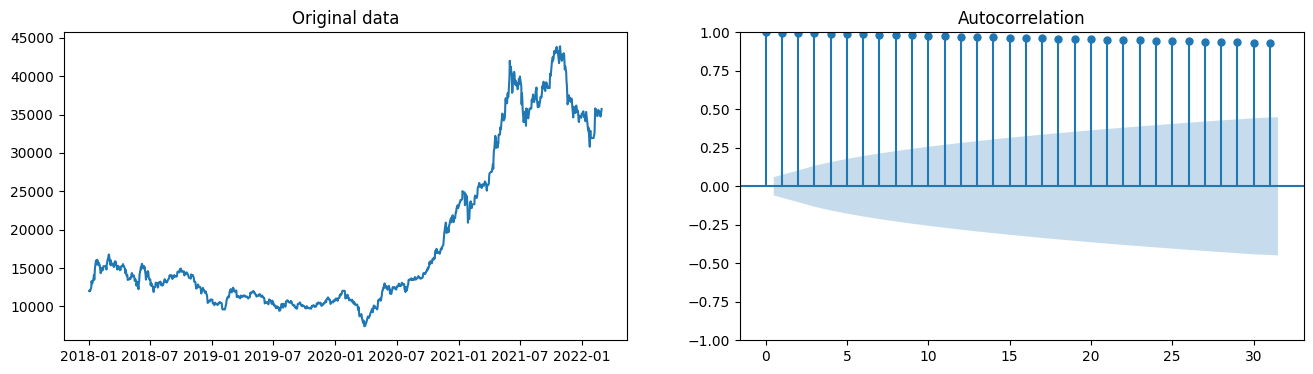

In [230]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(train)
ax1.set_title("Original data")

plot_acf(train, ax=ax2);

First-order differencing to make the series stationary (d = 1)

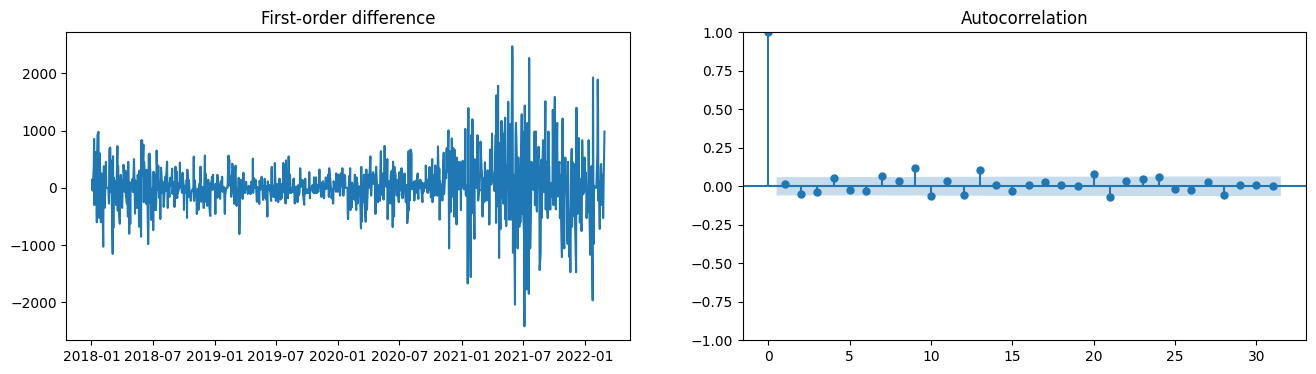

In [231]:
f_diff = train.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(f_diff)
ax1.set_title("First-order difference")
plot_acf(f_diff, ax=ax2);

In [232]:
result = adfuller(f_diff)
print("ADF Statistics:", result[0])
print("p-value", result[1])

ADF Statistics: -7.785492842915795
p-value 8.201064573119542e-12


Try d = 2

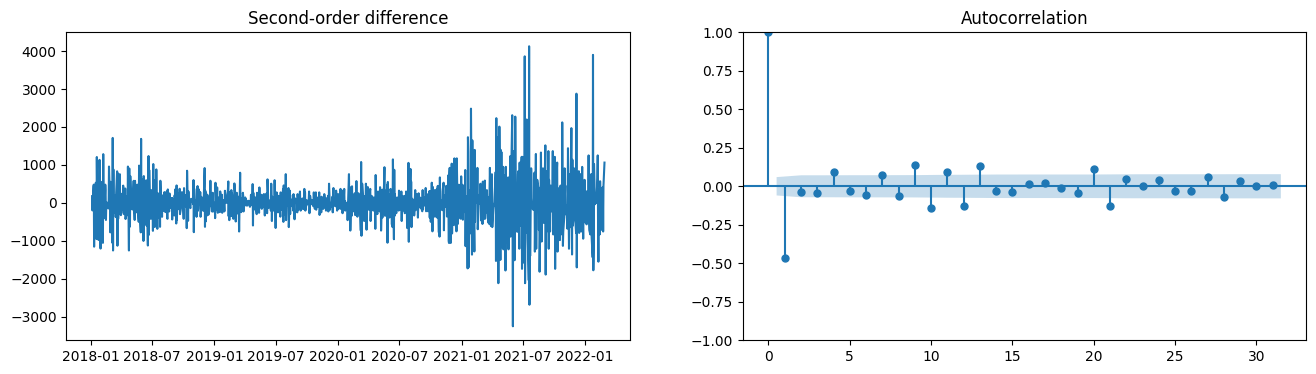

In [233]:
s_diff = train.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(s_diff)
ax1.set_title("Second-order difference")
plot_acf(s_diff, ax=ax2);

Determine p (order of the Auto Regressive (AR) term)

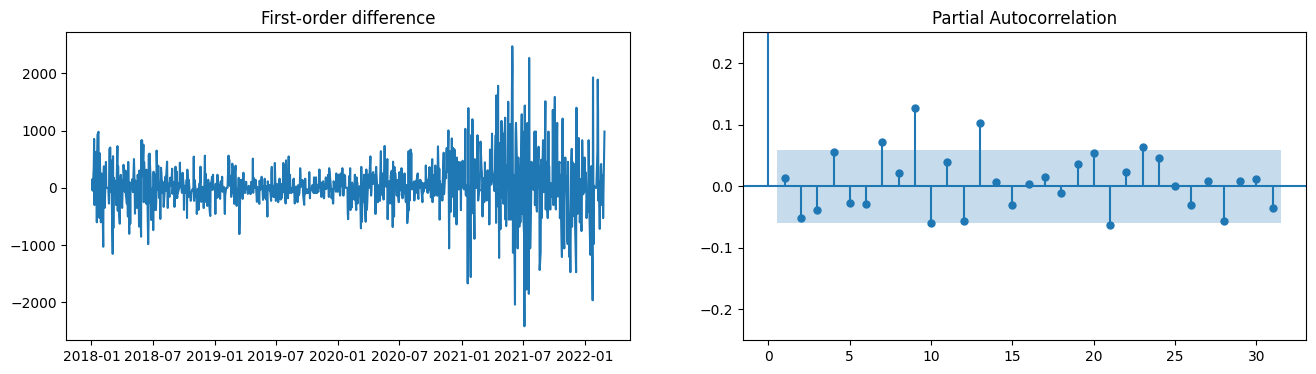

In [234]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(f_diff)
ax1.set_title("First-order difference")

plot_pacf(f_diff, ax=ax2)
ax2.set_ylim(-0.25,0.25);

Determine q (order of the Moving Average (MA) term)

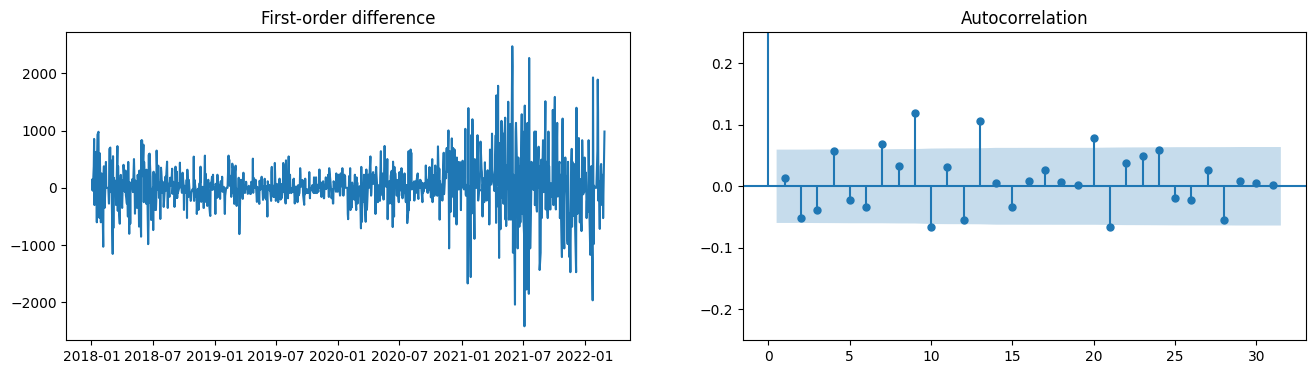

In [235]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(f_diff)
ax1.set_title("First-order difference")
plot_acf(f_diff, ax=ax2)
ax2.set_ylim(-0.25,0.25);

Model

Train on train

In [236]:
from pmdarima import auto_arima
step_fit = auto_arima(train, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16309.681, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16311.257, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16313.082, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16313.068, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16311.853, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16314.355, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16314.034, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16312.116, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=16307.533, Time=0.98 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=16312.716, Time=0.46 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=16308.236, Time=1.76 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=16313.798, Time=0.95 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=16312.264, Time=0.81 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=16310.745, Time=2.07 sec
 ARIMA(2,1,3)(0,0,0

In [237]:
step_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1085
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -8147.515
Date:                Sat, 01 Jun 2024   AIC                          16307.030
Time:                        20:56:23   BIC                          16336.960
Sample:                    01-02-2018   HQIC                         16318.361
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7491      0.019    -40.426      0.000      -0.785      -0.713
ar.L2         -0.9456      0.018    -51.747      0.000      -0.981      -0.910
ma.L1          0.7686      0.024     31.891      0.000       0.721       0.816
ma.L2          0.9430      0.026     36.048      0.000       0.892       0.994
ma.L3         -0.0190      0.019     -1.006      0.314      -0.056       0.018
sigma2      1.979e+05   4592.856     43.090      0.000    1.89e+05    2.07e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1293.20
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               4.97   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [238]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(2, 1, 3))

result = model.fit()

In [239]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 1085
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -8147.515
Date:                Sat, 01 Jun 2024   AIC                          16307.030
Time:                        20:56:24   BIC                          16336.960
Sample:                    01-02-2018   HQIC                         16318.361
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7491      0.019    -40.426      0.000      -0.785      -0.713
ar.L2         -0.9456      0.018    -51.747      0.000      -0.981      -0.910
ma.L1          0.7686      0.024     31.891      0.000       0.721       0.816
ma.L2          0.9430      0.026     36.048      0.000       0.892       0.994
ma.L3         -0.0190      0.019     -1.006      0.314      -0.056       0.018
sigma2      1.979e+05   4592.856     43.090      0.000    1.89e+05    2.07e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1293.20
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               4.97   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [240]:
start = len(train)
end = len(train) + len(test) - 1
pred = result.predict(start=start, end=end)

In [241]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


r2 = r2_score(test, pred)
print("R-squared:", r2)
mape = mean_absolute_percentage_error(test, pred)
print("MAPE:", mape)
rmse = math.sqrt(mean_squared_error(test, pred))
print("RMSE:", rmse)

R-squared: -4.81538007423587
MAPE: 76.84361372688339
RMSE: 15308.108440283899


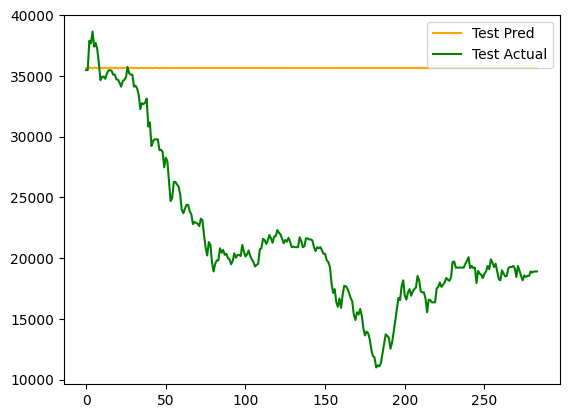

In [242]:
plt.plot(range(len(test)), pred, color ="orange", label = "Test Pred")
plt.plot(range(len(test)), test, color ="green", label = "Test Actual")
plt.legend()

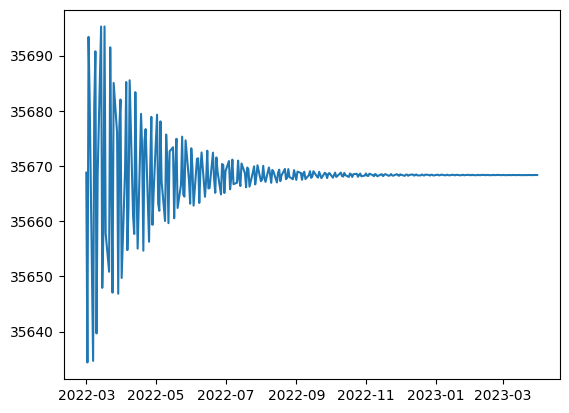

In [243]:
plt.plot(pred)

Train on dataset

In [244]:
step_fit = auto_arima(data, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24647.367, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24648.877, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24648.859, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24646.040, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24650.725, Time=0.35 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.651 seconds


In [245]:
model = ARIMA(data, order=(0, 1, 0))

result = model.fit()

In [246]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 1629
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -12322.020
Date:                Sat, 01 Jun 2024   AIC                          24646.040
Time:                        20:56:27   BIC                          24651.435
Sample:                    01-02-2018   HQIC                         24648.041
                         - 03-29-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.195e+05   4353.517     50.420      0.000    2.11e+05    2.28e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):              1222.50
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               3.71   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [247]:
start = len(train)
end = len(train) + len(test) - 1
pred = result.predict(start=start, end=end)

In [248]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


r2 = r2_score(test, pred)
print("R-squared:", r2)
mape = mean_absolute_percentage_error(test, pred)
print("MAPE:", mape)
rmse = math.sqrt(mean_squared_error(test, pred))
print("RMSE:", rmse)

R-squared: 0.9912297292312797
MAPE: 2.1346349671789904
RMSE: 594.4823689030817


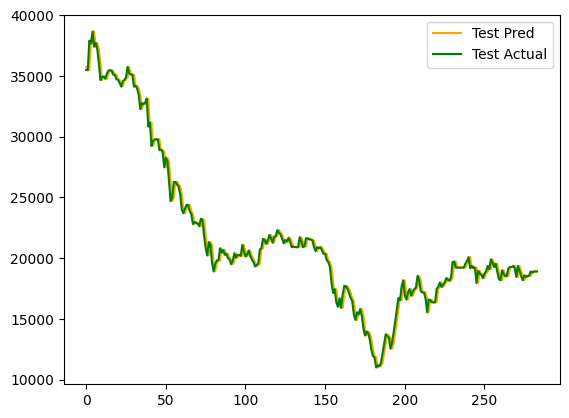

In [249]:
plt.plot(range(len(test)), pred, color ="orange", label = "Test Pred")
plt.plot(range(len(test)), test, color ="green", label = "Test Actual")
plt.legend()